## GRRR Forecast Skill and NiHSA Comparison

This notebook investigates Google's forecast skill at Wuro Bokki, Nigeria, and compares the reanalysis data against observational water level data from NiHSA. 

In [9]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from src.datasources import nihsa, grrr
from src.utils import rp_calc
import xskillscore as xs
from dotenv import load_dotenv

load_dotenv()

HYBAS_ID = "hybas_1120842550"
HYBAS_ID_ = "hybas_1120842990"  # Right at Wuro Bokki, but lower confidence
SAPPHIRE = "#007ce0"
TOMATO = "#f2645a"
TOMATO_DARK = "#c25048"
TOMATO_LIGHT = "#f7a29c"
MINT = "#1ebfb3"
GREY_DARK = "#888888"
GREY_LIGHT = "#cccccc"

# All years that include (very roughly) the flood season
NH_YEARS_PEAKS = [
    1982,
    1983,
    1988,
    1989,
    1991,
    1992,
    1993,
    2006,
    2007,
    2021,
    2013,
    2016,
    2018,
    2019,
    2020,
    2021,
    2023,
]

# And only more recent years as there seems to be a trend in increasing water level
NH_YEARS_RECENT_PEAKS = [
    2006,
    2007,
    2021,
    2013,
    2016,
    2018,
    2019,
    2020,
    2021,
    2023,
]

## Load in the GRRR data

In [11]:
ds_ra = grrr.load_reanalysis()
df_ra = grrr.process_reanalysis(ds_ra)

ds_rf = grrr.load_reforecast()
df_rf = grrr.process_reforecast(ds_rf)

ds_return_periods = grrr.load_return_periods()

/Users/hannahker/Desktop/ds-aa-nga-flooding/src/datasources/grrr.py:12: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  return xr.open_zarr(


### Return Periods

Get the Google-derived return periods

In [12]:
return_periods_dict = {}

for var_name in ds_return_periods.data_vars:
    return_periods_dict[int(var_name.split("_")[-1])] = ds_return_periods[
        var_name
    ].item()

df_rp = pd.DataFrame([return_periods_dict])
df_rp = (
    df_rp.T.reset_index()
    .rename(columns={"index": "return_period", 0: "streamflow"})
    .sort_values("return_period", ascending=True)
)

Now estimate return periods directly from the reanalysis data

In [13]:
return_periods = df_rp["return_period"]
df_rp_calculated = rp_calc.estimate_return_periods(
    df_ra,
    date_col="valid_time",
    val_col="streamflow",
    target_rps=list(return_periods),
)

Now plot both return periods

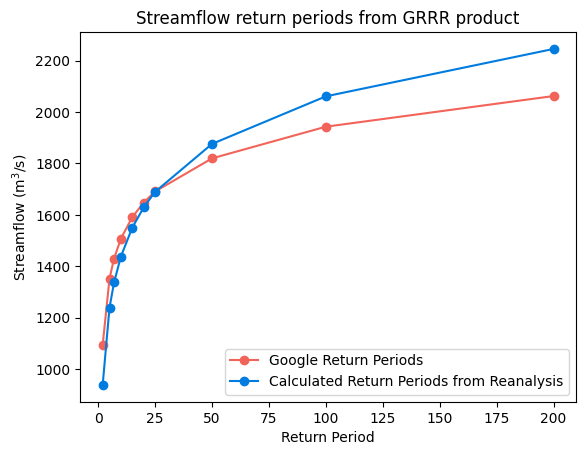

In [14]:
plt.plot(
    df_rp["return_period"],
    df_rp["streamflow"],
    "o-",
    c=TOMATO,
    label="Google Return Periods",
)
plt.plot(
    df_rp_calculated["return_period"],
    df_rp_calculated["value"],
    "o-",
    c=SAPPHIRE,
    label="Calculated Return Periods from Reanalysis",
)
plt.xlabel("Return Period")
plt.ylabel("Streamflow (m$^3$/s)")
plt.title("Streamflow return periods from GRRR product")
plt.legend()
plt.savefig(
    f"temp/{HYBAS_ID}_return_periods.png", dpi=300, bbox_inches="tight"
)
plt.show()

## Skill against reforecast

How well does the forecast match the model?

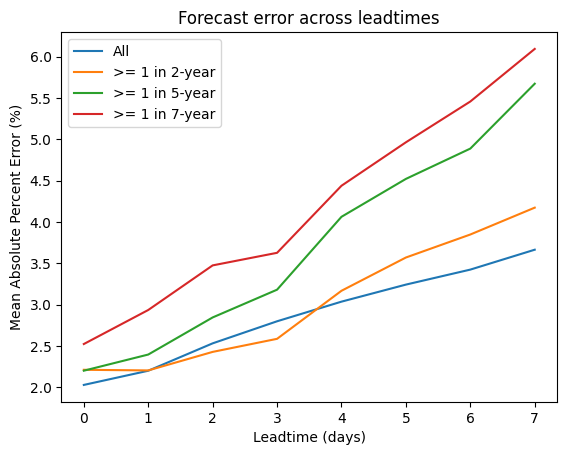

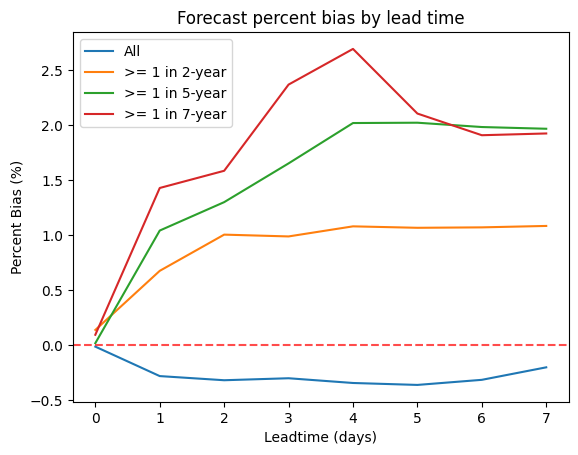

In [15]:
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()


def percent_bias(obs, pred):
    return 100.0 * sum(pred - obs) / sum(obs)


df_ra = df_ra.rename(columns={"streamflow": "streamflow_ra"})
df_rf = df_rf.rename(columns={"streamflow": "streamflow_rf"})
df_merged = df_rf.merge(df_ra, how="left")

for rp in [None, 2, 5, 7]:
    if rp:
        thresh = float(
            df_rp_calculated.loc[
                df_rp_calculated["return_period"] == rp, "value"
            ].iloc[0]
        )

        df_merged = df_merged[df_merged["streamflow_rf"] >= thresh]

    df_bias = (
        df_merged.groupby("leadtime")
        .apply(
            lambda x: percent_bias(x["streamflow_ra"], x["streamflow_rf"]),
            include_groups=False,
        )
        .reset_index(name="percent_bias")
    )

    dimension_cols = ["issue_time", "valid_time", "leadtime"]
    data_vars = ["streamflow_rf", "streamflow_ra"]

    indexed_df = df_merged.set_index(dimension_cols)
    ds = indexed_df[data_vars].to_xarray()

    df_skill = (
        ds.xs.mape(
            "streamflow_ra",
            "streamflow_rf",
            dim=["issue_time", "valid_time"],
            skipna=True,
        )
        .to_series()
        .reset_index()
        .rename(columns={0: "mape"})
    )
    label = f">= 1 in {rp}-year" if rp else "All"

    ax1.plot(
        df_skill["leadtime"],
        df_skill["mape"] * 100,
        label=label,
    )

    ax2.plot(
        df_bias["leadtime"],
        df_bias["percent_bias"],
        label=label,
    )

ax1.legend()
ax1.set_xlabel("Leadtime (days)")
ax1.set_ylabel("Mean Absolute Percent Error (%)")
ax1.set_title("Forecast error across leadtimes")

fig1.savefig(
    f"temp/{HYBAS_ID}_forecast_mape.png", dpi=300, bbox_inches="tight"
)

ax2.legend()
ax2.axhline(y=0, color="r", linestyle="--", alpha=0.7)
ax2.set_xlabel("Leadtime (days)")
ax2.set_ylabel("Percent Bias (%)")
ax2.set_title("Forecast percent bias by lead time")

fig2.savefig(
    f"temp/{HYBAS_ID}_forecast_bias.png", dpi=300, bbox_inches="tight"
)

## Load in the observational NIHSA data

In [16]:
df_nh = nihsa.load_wuroboki().rename(columns={"time": "valid_time"})

How well is the GRRR reanalysis data correlated with observational water levels at Wuro Boki?

In [17]:
df_merged = (
    df_nh.merge(df_ra, how="left")
    .dropna()
    .rename(columns={"streamflow_ra": "streamflow"})
)

Let's first break down by year

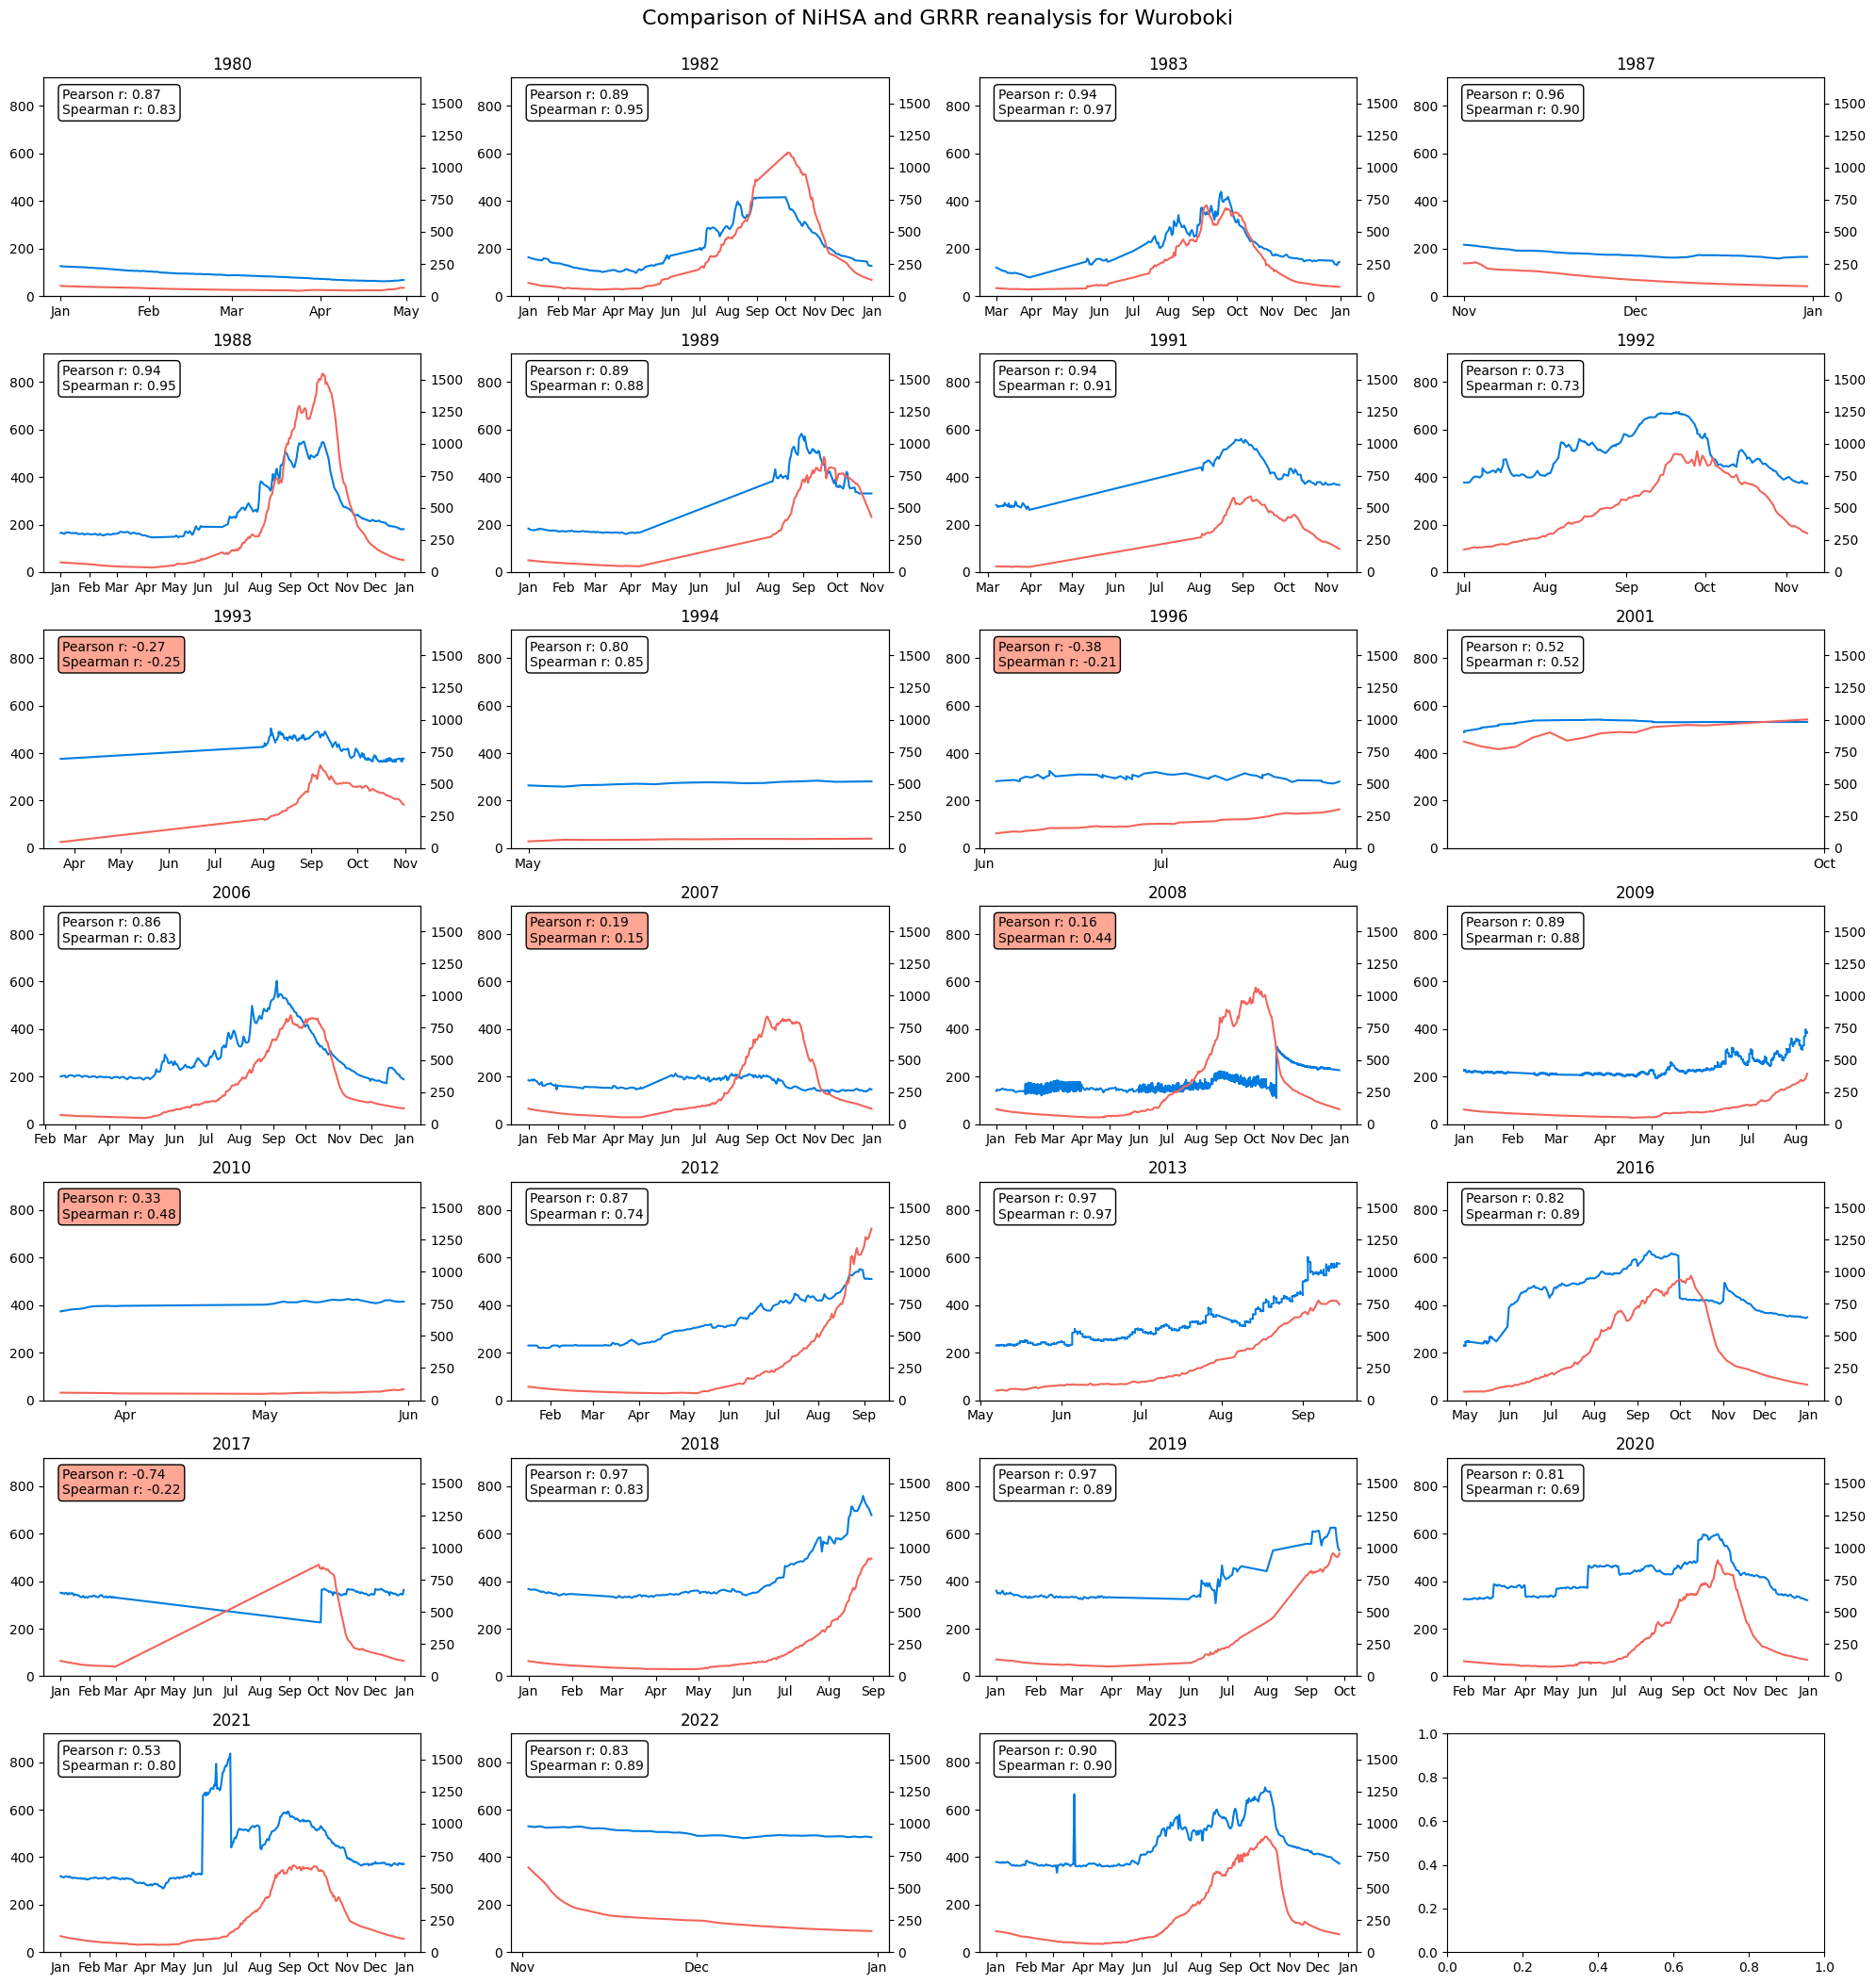

In [18]:
station_name = "Wuroboki"

dis_max = df_merged["streamflow"].max()
level_max = df_merged["level"].max()

n_years = df_merged["valid_time"].dt.year.nunique()

ncols = 4
nrows = round(n_years / ncols)

fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 3)
)
axes = axes.flatten()

year_correlations = {}

for j, year in enumerate(df_merged["valid_time"].dt.year.unique()):
    dff = df_merged[df_merged["valid_time"].dt.year == year]
    ax = axes[j]
    ax2 = ax.twinx()

    ax.plot(
        dff["valid_time"],
        dff["level"],
        color=SAPPHIRE,
        label="NiHSA\n(mm, left axis)",
    )
    ax.set_ylim(bottom=0, top=level_max * 1.1)

    ax2.plot(
        dff["valid_time"],
        dff["streamflow"],
        color=TOMATO,
        label="GRRR\n(m$^{3}$/s, right axis)",
    )

    ax2.set_ylim(bottom=0, top=dis_max * 1.1)

    pearson_r = dff["level"].corr(dff["streamflow"], method="pearson")
    spearman_r = dff["level"].corr(dff["streamflow"], method="spearman")

    year_correlations[year] = {
        "pearson_r": pearson_r,
        "spearman_r": spearman_r,
    }
    if pearson_r < 0.5 and spearman_r < 0.5:
        bbox_col = "#ffa694"  # Roughly which ones have bad relationship
    else:
        bbox_col = "white"

    ax.text(
        0.05,
        0.95,
        f"Pearson r: {pearson_r:.2f}\nSpearman r: {spearman_r:.2f}",
        transform=ax.transAxes,
        verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor=bbox_col),
    )

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.set_title(year)

fig.suptitle(
    f"Comparison of NiHSA and GRRR reanalysis for {station_name.capitalize()}",
    fontsize=16,
    y=1,
)
plt.savefig(
    f"temp/{HYBAS_ID}_nihsa_correlation.png", dpi=300, bbox_inches="tight"
)
plt.tight_layout()

Now look at overall


Overall Pearson correlation: 0.3084
Overall Spearman correlation: 0.3453


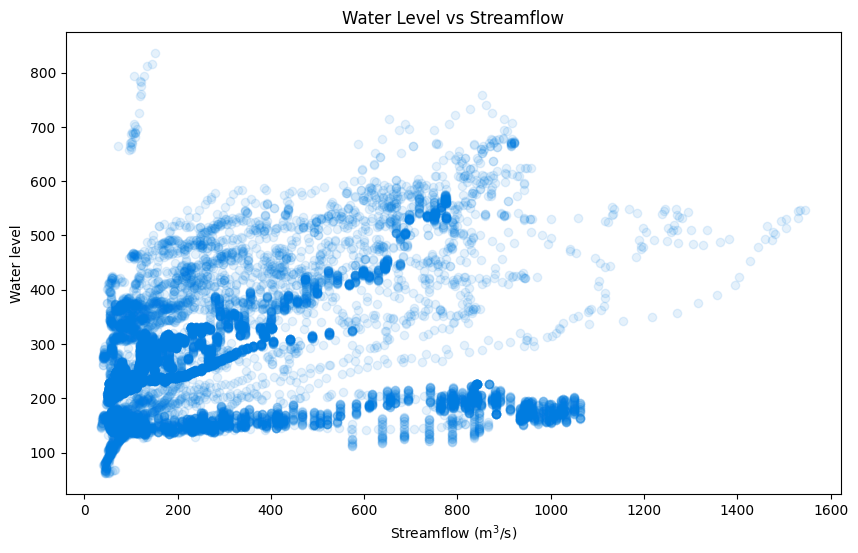

In [19]:
pearson_corr = df_merged["level"].corr(
    df_merged["streamflow"], method="pearson"
)
spearman_corr = df_merged["level"].corr(
    df_merged["streamflow"], method="spearman"
)
print(f"\nOverall Pearson correlation: {pearson_corr:.4f}")
print(f"Overall Spearman correlation: {spearman_corr:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(df_merged["streamflow"], df_merged["level"], alpha=0.1, c=SAPPHIRE)
plt.title("Water Level vs Streamflow")
plt.xlabel("Streamflow (m$^{3}$/s)")
plt.ylabel("Water level")

plt.savefig(
    f"temp/{HYBAS_ID}_nihsa_correlation_overall.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()

## Return period exceedance

Let's start by calculating the yearly peaks

In [20]:
# First let's only take the observational data since 1980
# to match with the reanalysis
df_nh = df_nh[df_nh["valid_time"] > "1980-01-01"]

# Also fill in all the date gaps with null values for better plotting
date_range = pd.date_range(
    start=df_nh["valid_time"].min(),
    end=df_nh["valid_time"].max(),
    freq="D",
)

df_nh_complete = pd.DataFrame({"valid_time": date_range})
df_nh_complete = df_nh_complete.merge(df_nh, on="valid_time", how="left")

In [21]:
df_nh_peaks = (
    df_nh.groupby(df_nh["valid_time"].dt.year.rename("year"))
    .agg(
        level_max=("level", "max"),
        level_max_date=(
            "level",
            lambda x: df_nh.loc[x.idxmax(), "valid_time"],
        ),
    )
    .reset_index()
)

df_nh_peaks_recent = df_nh_peaks[df_nh_peaks.year.isin(NH_YEARS_PEAKS)]

For the observational data

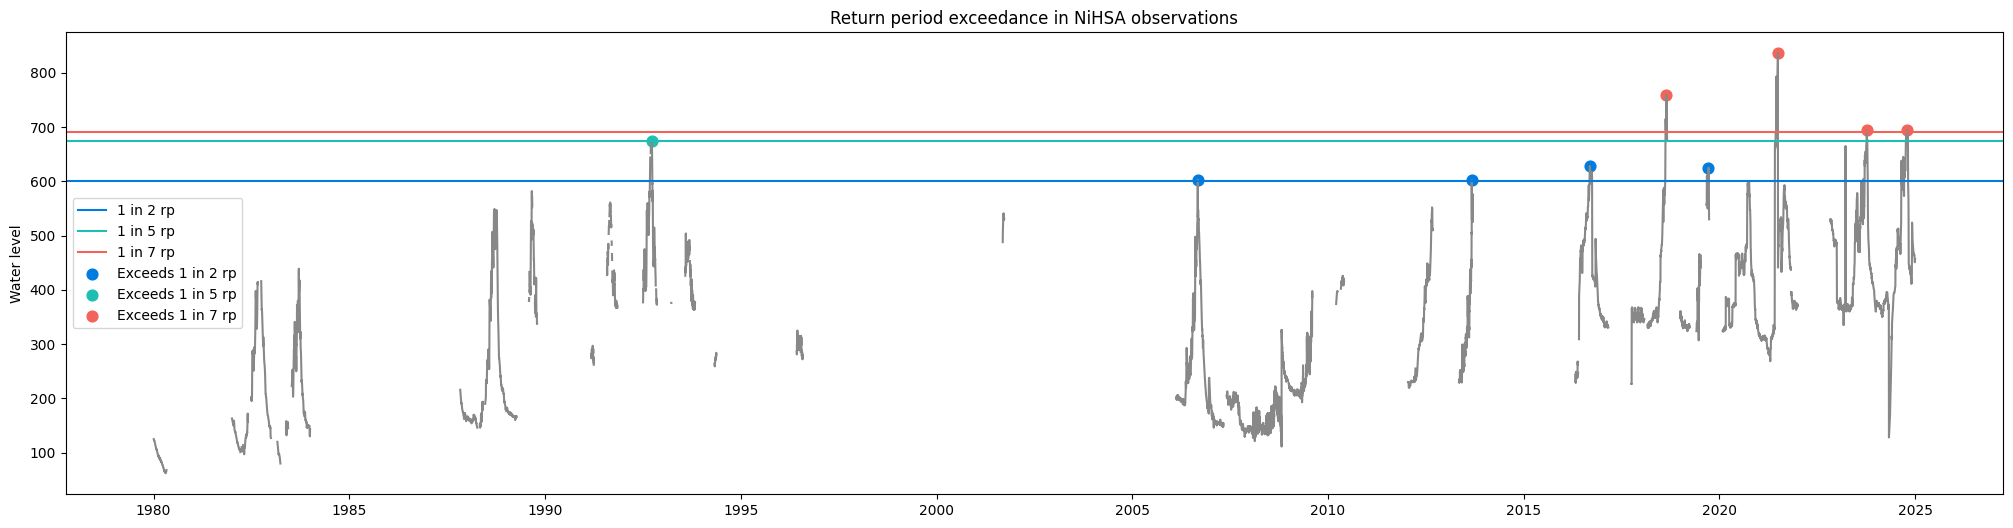

In [22]:
rp_2_nh = df_nh_peaks_recent["level_max"].quantile(1 - 1 / 2)
rp_5_nh = df_nh_peaks_recent["level_max"].quantile(1 - 1 / 5)
rp_7_nh = df_nh_peaks_recent["level_max"].quantile(1 - 1 / 7)

fig, ax = plt.subplots(figsize=(25, 6))

ax.plot(df_nh_complete["valid_time"], df_nh_complete["level"], c=GREY_DARK)
ax.axhline(rp_2_nh, c=SAPPHIRE, label="1 in 2 rp")
ax.axhline(rp_5_nh, c=MINT, label="1 in 5 rp")
ax.axhline(rp_7_nh, c=TOMATO, label="1 in 7 rp")

mask_rp2 = df_nh_peaks["level_max"] >= rp_2_nh
mask_rp5 = df_nh_peaks["level_max"] >= rp_5_nh
mask_rp7 = df_nh_peaks["level_max"] >= rp_7_nh

ax.scatter(
    df_nh_peaks.loc[mask_rp2 & ~mask_rp5, "level_max_date"],
    df_nh_peaks.loc[mask_rp2 & ~mask_rp5, "level_max"],
    c=SAPPHIRE,
    s=60,
    label="Exceeds 1 in 2 rp",
)
ax.scatter(
    df_nh_peaks.loc[mask_rp5 & ~mask_rp7, "level_max_date"],
    df_nh_peaks.loc[mask_rp5 & ~mask_rp7, "level_max"],
    c=MINT,
    s=60,
    label="Exceeds 1 in 5 rp",
)
ax.scatter(
    df_nh_peaks.loc[mask_rp7, "level_max_date"],
    df_nh_peaks.loc[mask_rp7, "level_max"],
    c=TOMATO,
    s=60,
    label="Exceeds 1 in 7 rp",
)

ax.set_ylabel("Water level")
ax.set_title("Return period exceedance in NiHSA observations")
plt.savefig(f"temp/nihsa_rp_exceedance.png", dpi=300, bbox_inches="tight")
plt.legend()

For the reanalysis data

In [23]:
df_ra_peaks = (
    df_ra.groupby(df_ra["valid_time"].dt.year.rename("year"))
    .agg(
        sf_max=("streamflow_ra", "max"),
        sf_max_date=(
            "streamflow_ra",
            lambda x: df_ra.loc[x.idxmax(), "valid_time"],
        ),
    )
    .reset_index()
)

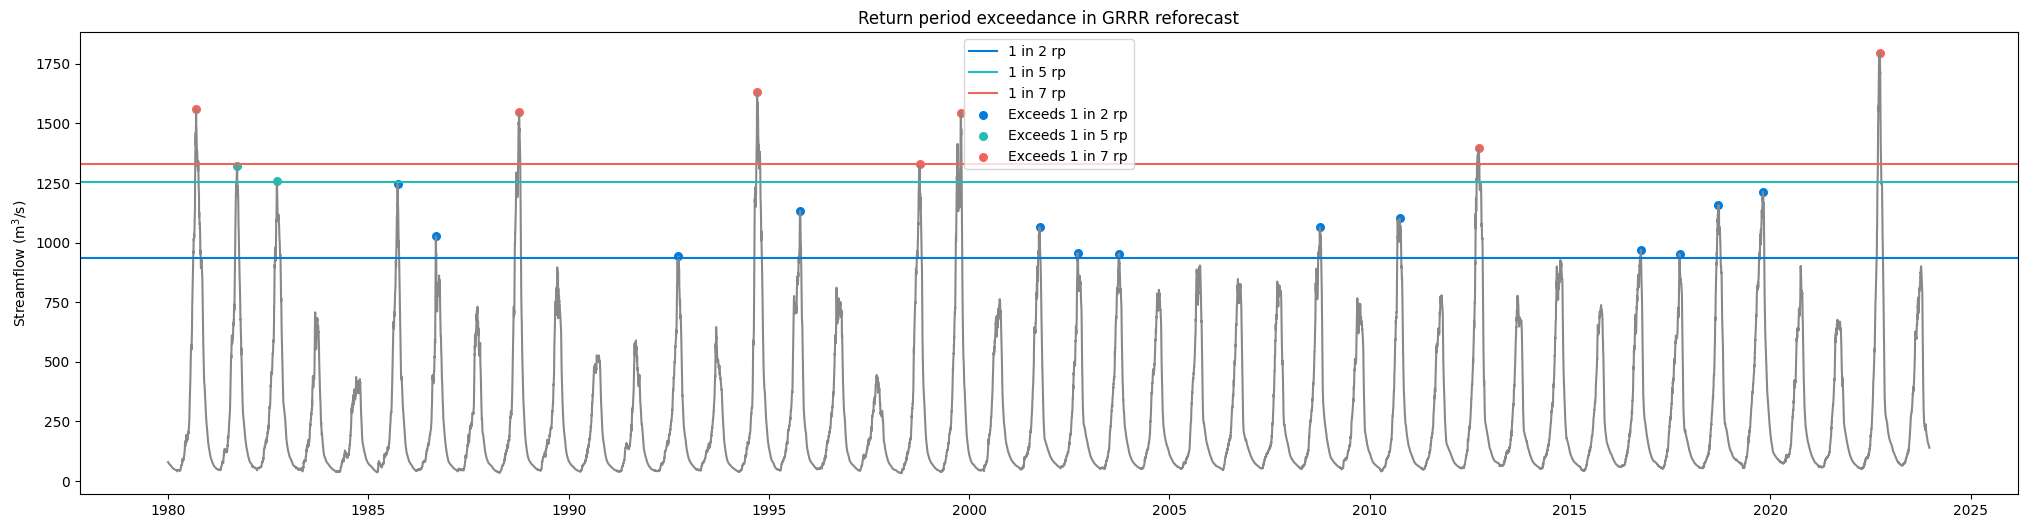

In [24]:
rp_2_ra = df_ra_peaks["sf_max"].quantile(1 - 1 / 2)
rp_5_ra = df_ra_peaks["sf_max"].quantile(1 - 1 / 5)
rp_7_ra = df_ra_peaks["sf_max"].quantile(1 - 1 / 7)

fig, ax = plt.subplots(figsize=(25, 6))

ax.plot(df_ra["valid_time"], df_ra["streamflow_ra"], c=GREY_DARK)
ax.axhline(rp_2_ra, c=SAPPHIRE, label="1 in 2 rp")
ax.axhline(rp_5_ra, c=MINT, label="1 in 5 rp")
ax.axhline(rp_7_ra, c=TOMATO, label="1 in 7 rp")

mask_rp2 = df_ra_peaks["sf_max"] >= rp_2_ra
mask_rp5 = df_ra_peaks["sf_max"] >= rp_5_ra
mask_rp7 = df_ra_peaks["sf_max"] >= rp_7_ra

ax.scatter(
    df_ra_peaks.loc[mask_rp2 & ~mask_rp5, "sf_max_date"],
    df_ra_peaks.loc[mask_rp2 & ~mask_rp5, "sf_max"],
    c=SAPPHIRE,
    s=30,
    label="Exceeds 1 in 2 rp",
)
ax.scatter(
    df_ra_peaks.loc[mask_rp5 & ~mask_rp7, "sf_max_date"],
    df_ra_peaks.loc[mask_rp5 & ~mask_rp7, "sf_max"],
    c=MINT,
    s=30,
    label="Exceeds 1 in 5 rp",
)
ax.scatter(
    df_ra_peaks.loc[mask_rp7, "sf_max_date"],
    df_ra_peaks.loc[mask_rp7, "sf_max"],
    c=TOMATO,
    s=30,
    label="Exceeds 1 in 7 rp",
)
ax.set_ylabel("Streamflow (m$^3$/s)")
ax.set_title("Return period exceedance in GRRR reforecast")
plt.savefig(f"temp/{HYBAS_ID}_rp_exceedance.png", dpi=300, bbox_inches="tight")
plt.legend()

Now let's look at the yearly peaks

In [25]:
df_all_peaks = df_nh_peaks.merge(df_ra_peaks, how="inner")
df_all_peaks = df_all_peaks[df_all_peaks.year.isin(NH_YEARS_PEAKS)]

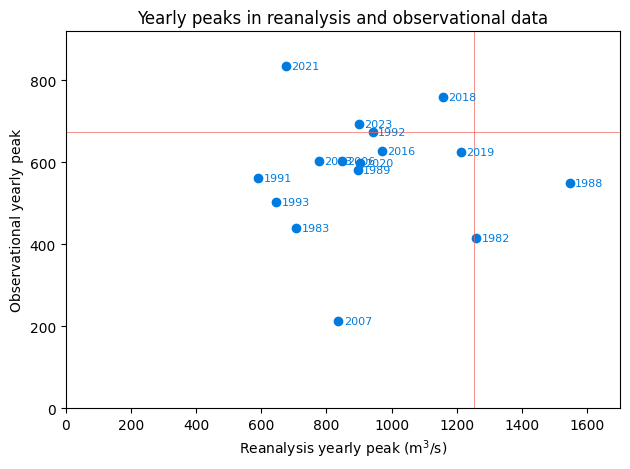

In [26]:
fig, ax = plt.subplots()

ax.scatter(df_all_peaks["sf_max"], df_all_peaks["level_max"], c="#007ce0")

for idx, row in df_all_peaks.iterrows():
    ax.annotate(
        row["year"],
        (row["sf_max"] + 60, row["level_max"]),
        ha="center",
        va="center",
        fontsize=8,
        c="#007ce0",
    )

ax.axvline(rp_5_ra, lw=0.5, c=TOMATO)
ax.axhline(rp_5_nh, lw=0.5, c=TOMATO)

ax.set_ylim(bottom=0, top=df_all_peaks["level_max"].max() * 1.1)
ax.set_xlim(left=0, right=df_all_peaks["sf_max"].max() * 1.1)
ax.set_xlabel("Reanalysis yearly peak (m$^{3}$/s)")
ax.set_ylabel("Observational yearly peak")
ax.set_title("Yearly peaks in reanalysis and observational data")
plt.savefig(f"temp/{HYBAS_ID}_yearly_peaks.png", dpi=300, bbox_inches="tight")
plt.tight_layout()

In [27]:
def determine_detection_type(row, rp_5_nh, rp_5_ra):
    happened = row["level_max"] > rp_5_nh
    detected = row["sf_max"] > rp_5_ra

    if happened and detected:
        return "TP"  # True Positive
    elif not happened and detected:
        return "FP"  # False Positive
    elif not happened and not detected:
        return "TN"  # True Negative
    else:
        return "FN"  # False Negative


def get_more_stats(TP, FP, FN):
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 / ((1 / recall) + (1 / precision))
    return precision, recall, f1


df_all_peaks["detection_type"] = df_all_peaks.apply(
    lambda row: determine_detection_type(row, rp_5_nh, rp_5_ra), axis=1
)

In [28]:
counts = df_all_peaks["detection_type"].value_counts().to_dict()

In [29]:
counts

{'TN': 11, 'FN': 3, 'FP': 2}

In [30]:
if "TP" not in counts.keys():
    counts["TP"] = 0

Division by zero here... makes sense since there's no TPs...

In [31]:
precision, recall, f1 = get_more_stats(
    counts["TP"], counts["FP"], counts["FN"]
)

ZeroDivisionError: float division by zero